In [2]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.signal import welch

Cargamos los datos

In [3]:
eeg1 = pd.read_csv("participantes/eeg_pp_8.csv")

features1 = pd.read_csv("participantes/eeg_features_8.csv")

In [92]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00072,-29.31987,-30.30657,-12.06080,-15.90713,-23.11948,-24.29741,-16.752820,-6.195919,-11.26489,-14.23159,-18.50026,-8.201546,-9.119677,-13.62377,-14.63473,-10.96609,-19.62792,-21.663300,-18.50442
1,0.00463,-39.24020,-37.79444,-18.39936,-22.31810,-31.46937,-34.78954,-23.034120,-15.319120,-13.40990,-21.23121,-23.27748,-12.965020,-16.185820,-17.30415,-19.16477,-18.83134,-23.51070,-20.550730,-21.68161
2,0.00853,-41.87741,-37.07481,-21.08630,-22.66264,-33.46293,-39.34344,-23.111890,-20.664030,-14.14052,-23.73416,-25.38597,-16.359070,-19.666170,-16.76995,-19.34562,-24.48707,-20.90921,-10.054820,-18.59622
3,0.01244,-35.06359,-27.47393,-18.94675,-16.52623,-27.60163,-35.94439,-16.326670,-19.149810,-12.75907,-19.77020,-22.30418,-18.222450,-18.128600,-13.16649,-16.05393,-25.37166,-16.85848,-0.330784,-13.68042
4,0.01634,-26.44231,-19.07599,-13.49381,-10.03094,-20.55467,-29.62936,-9.338481,-13.729210,-10.23374,-13.93872,-16.40924,-15.397990,-14.251280,-10.61654,-13.14343,-21.16089,-18.75200,-2.366364,-13.44962


In [4]:
len(eeg1), len(features1)

(93440, 2320)

In [93]:
features1.isnull().sum()

epoch                   0
window                  0
n_samples               0
Start_w                 0
End_w                   0
                       ..
ch19-LowGamma-Kurt      0
ch19-LowGamma-RelPow    0
ch19-LowGamma-HjAct     0
ch19-LowGamma-HjMob     0
ch19-LowGamma-HjComp    0
Length: 1261, dtype: int64

In [6]:
features1['Trust'].value_counts(dropna=False)

Trust
5.0    850
3.0    400
NaN    320
1.0    300
4.0    250
2.0    200
Name: count, dtype: int64

In [4]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [5]:
import numpy as np

def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_34856\2382396194.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 29303 de un total de 93440

Distribución Binary_Trust:
Binary_Trust
high_trust    35554
NaN           29303
low_trust     28583
Name: count, dtype: int64

Distribución Trust:
Trust
NaN    29303
5.0    27174
3.0    12536
1.0     9204
4.0     8380
2.0     6843
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [6]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 64137

Distribución Binary_Trust:
Binary_Trust
high_trust    35554
low_trust     28583
Name: count, dtype: int64

Distribución Trust:
Trust
5.0    27174
3.0    12536
1.0     9204
4.0     8380
2.0     6843
Name: count, dtype: int64


C:\Users\crist\AppData\Local\Temp\ipykernel_31928\3394219416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


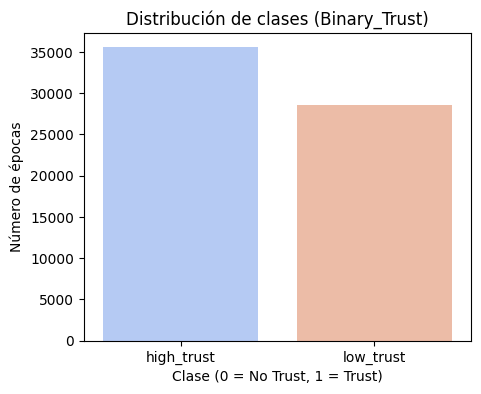

Distribución porcentual:
 Binary_Trust
high_trust    0.554345
low_trust     0.445655
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

## Almacén de resultados

In [7]:
import os
def save_f1_history(clf, architecture, participant):
    f1_curve = clf.history_[:, 'f1_macro']
    df_new = pd.DataFrame({
        'epoch': range(1, len(f1_curve)+1),
        'f1': f1_curve,
        'architecture': architecture,
        'participant': participant
    })

    filename = "historial_f1_global.csv"

    if os.path.exists(filename):
        df_old = pd.read_csv(filename)
        df_final = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_final = df_new

    df_final.to_csv(filename, index=False)
    print(f"Guardado en {filename}")


## Red Neuronal EEGNet

In [8]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [142]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 256.40689570847803


### Trial Wise

Dividimos los datos de manera que no queden muestras mezcladas en los distintos conjuntos de entrenamiento, validación y test

In [45]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación 
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)




torch.Size([568, 19, 256]) torch.Size([568])


### Selección de características

#### Métodos de filtro

In [47]:
# === 2. Selección de canales (ANOVA) ===
from sklearn.feature_selection import f_classif

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 10  
selected_channels = np.argsort(F_values)[-k:]  
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [11 18  5 12 14  2 16  3  6  9]
Nueva forma de X_train: torch.Size([568, 10, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]  

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [ 1 14  8  6  9  5  7  4 13 18]
Nueva forma de X_train: torch.Size([568, 10, 256])


#### Método híbrido (filter+wrapper)

In [112]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)


Canales finales (híbrido): [12 11  1  8  6  9  5  4 13 18]


### Normalización de los datos

In [46]:
mean = X_train_t.mean(dim=(0,2), keepdim=True) 
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


In [439]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [ ]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 537
Valid windows: 161
Test windows: 214
epoch
2.0        50
3.0       453
4.0       613
5.0      1517
6.0       202
         ... 
221.0      50
222.0     311
223.0     639
224.0     255
225.0     127
Length: 200, dtype: int64
Media de muestras por trial: 339.49
Mínimo de muestras por trial: 45
Máximo de muestras por trial: 1517


### Modelo y entrenamiento

#### Creación del modelo

In [13]:
chans = 19    
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss()

#### Entrenamiento del modelo

In [15]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [16]:
clf.fit(X_train_t, y_train_t)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.5035        0.7032       0.5075        0.6948  1.0230
      2      0.5813        0.6989       0.5821        0.6933  0.6321
      3      0.5637        0.6900       0.5672        0.6913  0.5483
      4      0.5967        0.6723       0.5970        0.6901  1.0363
      5      0.5668        0.6536       0.5672        0.6889  0.9567
      6      0.5656        0.6593       0.5672        0.6869  0.8051
      7      0.5497        0.6439       0.5522        0.6854  0.5436
      8      0.6564        0.6160       0.6567        0.6820  0.5333
      9      0.6265        0.6010       0.6269        0.6818  0.5136
     10      0.5668        0.5849       0.5672        0.6797  0.5210
     11      0.6077        0.5726       0.6119        0.6726  0.4775
     12      0.5410        0.5486       0.5672        0.6706  0.5270
     13      0.5248        0.5378 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [17]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[ 35  38]
 [  9 111]]
              precision    recall  f1-score   support

           0       0.80      0.48      0.60        73
           1       0.74      0.93      0.83       120

    accuracy                           0.76       193
   macro avg       0.77      0.70      0.71       193
weighted avg       0.76      0.76      0.74       193



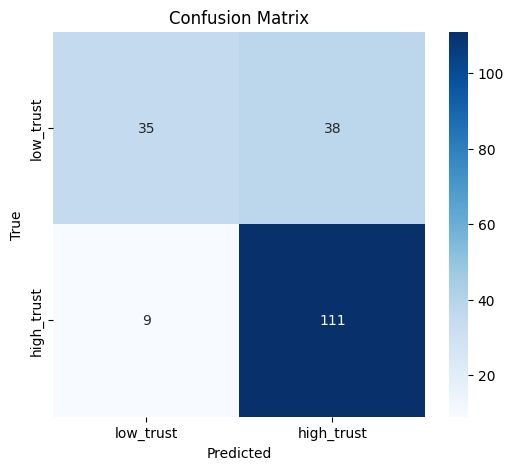

In [18]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Opcional: nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1] 
y_true = y_test_t.numpy()

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.806


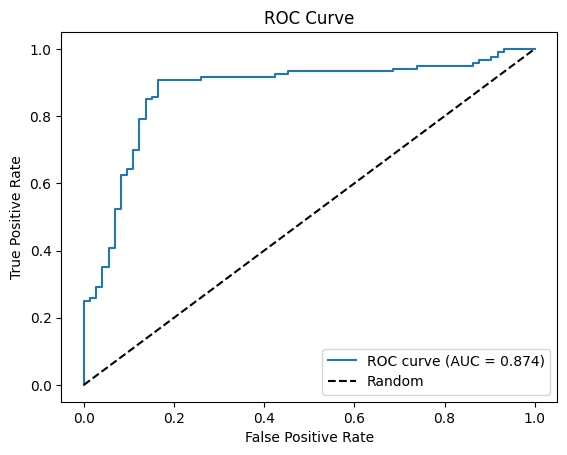

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [330]:
save_f1_history(
    clf=clf,
    architecture="EEGNet",
    participant="P8"
)

Guardado en historial_f1_global.csv


### RED EEGNeX

In [20]:
from braindecode.models import EEGNeX

In [48]:
chans = 10
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss()

In [50]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro,
               ],
    max_epochs=30,
    device='cpu',
)


In [51]:
clf.fit(
    X_train_t, 
    y_train_t, 
)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.3738        0.6724       0.5970        0.6734  9.3610
      2      0.3738        0.6008       0.5970        0.6670  23.3807
      3      0.6059        0.5677       0.7015        0.6879  34.3566
      4      0.5601        0.5206       0.6119        0.7155  9.6886
      5      0.5601        0.4931       0.6119        0.7163  12.1471
      6      0.5939        0.4483       0.6418        0.6768  13.2053
      7      0.6326        0.3983       0.7164        0.5708  15.8368
      8      0.6747        0.3500       0.7164        0.5135  14.7859
      9      0.7226        0.3152       0.7612        0.4915  22.5824
     10      0.7156        0.2797       0.7463        0.4582  15.8457
     11      0.6821        0.2875       0.7164        0.4538  7.8887
     12      0.7293        0.2552       0.7612        0.4574  8.7355
     13      0.6616       

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 10, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 10, 256]              [1, 8, 10, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 10, 256]              [1, 1, 10, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 10, 256]           [1, 8, 10, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 10, 256]           [1, 8, 10, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 10, 256]           [1, 32, 10, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 10, 256]           [1, 32, 10, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 10, 256]          [1, 32, 10, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 10, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 10, 256]          [1, 64, 1, 256]           --                        [10, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        640                       --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [52]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[68  5]
 [22 98]]
              precision    recall  f1-score   support

           0       0.76      0.93      0.83        73
           1       0.95      0.82      0.88       120

    accuracy                           0.86       193
   macro avg       0.85      0.87      0.86       193
weighted avg       0.88      0.86      0.86       193



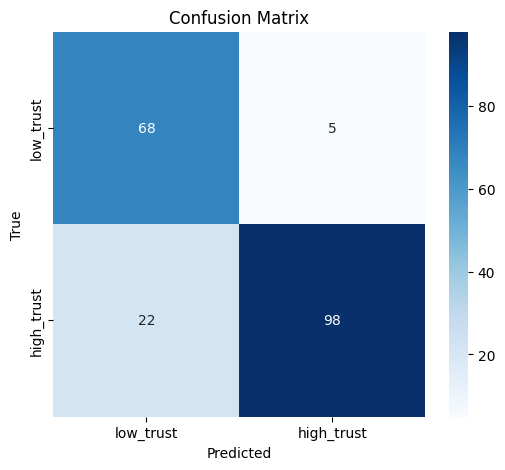

In [53]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nmbres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [54]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")



ROC-AUC: 0.909


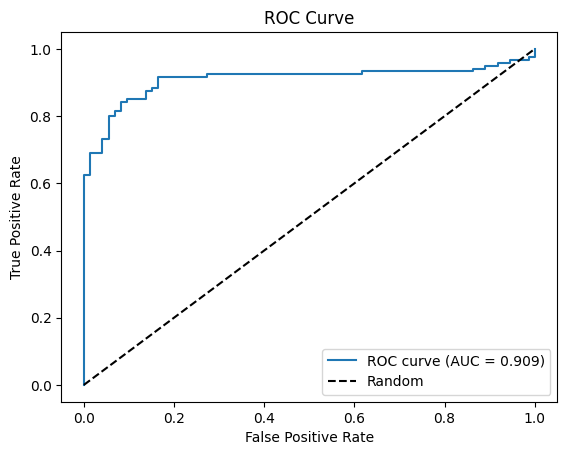

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [337]:
save_f1_history(
    clf=clf,
    architecture="EEGNeX",
    participant="P8"
)

Guardado en historial_f1_global.csv


### Almacén del modelo

In [56]:
import os
import pickle

subject_id = 'P8'
folder_path = 'artifacts/p8'
os.makedirs(folder_path, exist_ok=True)

# Guardar modelo y configuración
try:
    # Guardamos los pesos del modelo y optimizador 
    clf.save_params(
        f_params=os.path.join(folder_path, f'model_weights_{subject_id}.pt'),
        f_optimizer=os.path.join(folder_path, f'opt_{subject_id}.pt'),
        f_history=os.path.join(folder_path, f'history_{subject_id}.json')
    )
    
    # Guardamos los hiperparámetros 
    config_params = clf.get_params()
    config_params.pop('module', None) 
    
    with open(os.path.join(folder_path, f'config_{subject_id}.pkl'), 'wb') as f:
        pickle.dump(config_params, f)

except RuntimeError:
    import torch
    torch.save(clf.module_.state_dict(), os.path.join(folder_path, f'state_dict_{subject_id}.pt'))

# GUARDAR PREDICCIONES 
y_pred = clf.predict(X_test_t)
y_probs = clf.predict_proba(X_test_t)[:, 1]

df_preds = pd.DataFrame({
    'Real': y_test_t.cpu().numpy() if hasattr(y_test_t, 'cpu') else y_test_t,
    'Prediccion': y_pred,
    'Probabilidad': y_probs
})

df_preds.to_excel(os.path.join(folder_path, f'predicciones_{subject_id}.xlsx'), index=False)



## Attention Based Net

In [28]:
from braindecode.models import AttentionBaseNet


In [33]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.2,
    drop_prob_attn= 0.5,

)


In [34]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss()

In [35]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='f1_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [36]:
clf.fit(
    X_train_t, 
    y_train_t, 
)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4433        0.7525       0.4478        0.6969  0.8443
      2      0.4213        0.6779       0.5373        0.6945  1.1823
      3      0.4482        0.6464       0.4925        0.6961  0.8794
      4      0.4657        0.6234       0.4776        0.7091  0.7787
      5      0.3964        0.6073       0.4030        0.7384  0.8133
      6      0.4132        0.5974       0.4179        0.7715  0.7901
      7      0.4352        0.5639       0.4478        0.7616  0.8421
      8      0.4603        0.5568       0.4776        0.7483  0.8864
      9      0.5037        0.5483       0.5224        0.7586  0.9041
     10      0.4972        0.5417       0.5224        0.7269  0.9512
     11      0.5093        0.5003       0.5373        0.7198  0.8975
     12      0.5366        0.4672       0.5821        0.6887  0.8612
     13      0.5839        0.4571 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [37]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[66  7]
 [33 87]]
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        73
           1       0.93      0.72      0.81       120

    accuracy                           0.79       193
   macro avg       0.80      0.81      0.79       193
weighted avg       0.83      0.79      0.80       193



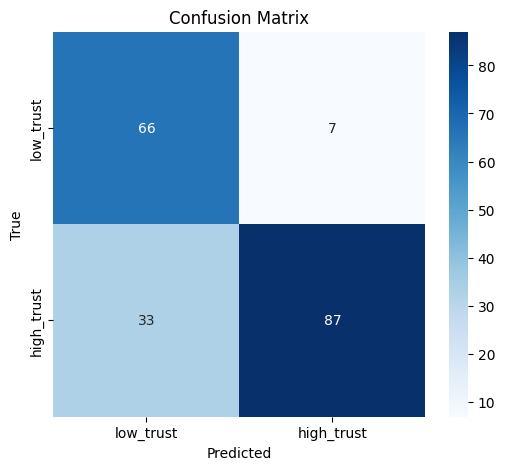

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [39]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")




ROC-AUC: 0.885


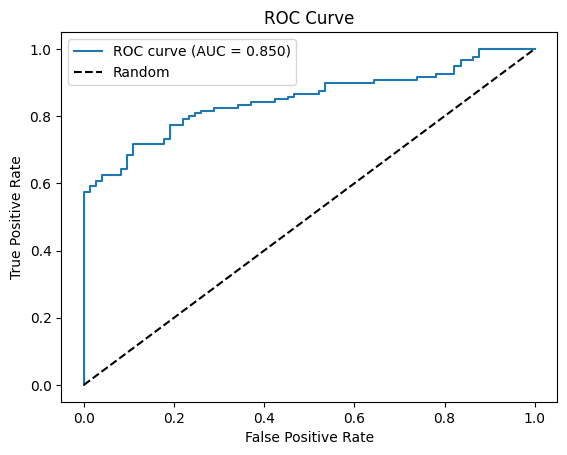

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [344]:
save_f1_history(
    clf=clf,
    architecture="AttentionBaseNet",
    participant="P8"
)

Guardado en historial_f1_global.csv


## Análisis espectral

In [ ]:
def build_trial_matrix(df):
    trials = df['epoch'].unique()

    X_trials = []
    y_trials = []

    bad_trials = []

    for trial in trials:
        trial_df = df[df['epoch'] == trial]

        # Eliminar columnas no EEG
        trial_df = trial_df.drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')

        signal = trial_df.values.T  

        # Forma mínima
        if len(signal.shape) != 2:
            bad_trials.append((trial, signal.shape))
            continue

        # Revisar si hay más de 1 sample
        if signal.shape[1] < 20:  # señal demasiado corta = corrupta
            bad_trials.append((trial, signal.shape))
            continue

        # Etiqueta
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        y_bin = 0 if label == 'low_trust' else 1

        X_trials.append(signal)
        y_trials.append(y_bin)

    print("Trials corruptos detectados:", bad_trials)

    return X_trials, np.array(y_trials)


In [41]:
X_trials, y_trials = build_trial_matrix(eeg1)


Trials corruptos detectados: []


In [42]:
def normalize_trial_lengths(X_trials):
    Lmin = min(x.shape[1] for x in X_trials)
    X_cut = [x[:, :Lmin] for x in X_trials]
    return X_cut


In [43]:
from scipy.signal import welch

def psd_trials(X_trials, y_trials, sfreq=256):
    classes = np.unique(y_trials)
    psd_class = {}

    for cls in classes:
        trials = [X_trials[i] for i in range(len(X_trials)) if y_trials[i] == cls]

        psds = []
        for trial in trials:
            f, Pxx = welch(trial, sfreq, axis=1, nperseg=sfreq*2)
            psds.append(Pxx.mean(axis=0))

        psd_class[cls] = np.mean(psds, axis=0)

    plt.figure(figsize=(10,5))
    for cls in classes:
        plt.plot(f, psd_class[cls], label=f"Clase {cls}")
    plt.legend()
    plt.title(f"PSD por clase")
    plt.xlabel("Hz")
    plt.show()


Trials corruptos detectados: []


c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 512 is greater than input length  = 48, using nperseg = 48
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


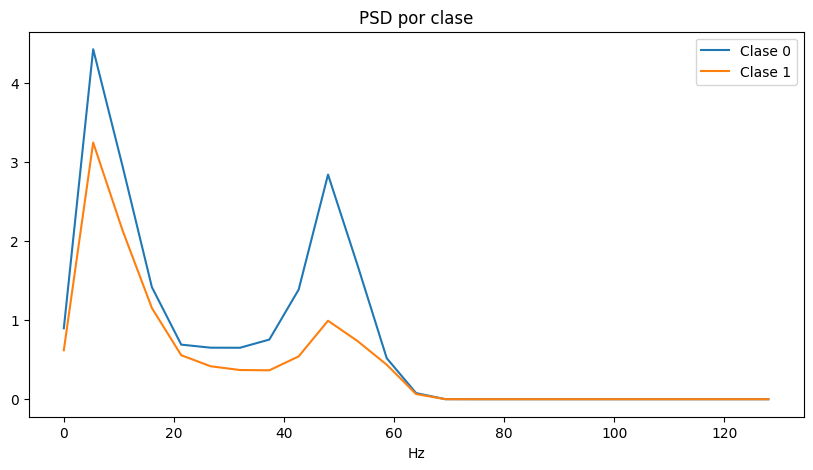

In [44]:
X_trials, y_trials = build_trial_matrix(eeg1)
X_trials = normalize_trial_lengths(X_trials)
psd_trials(X_trials, y_trials)